In [1]:
import pandas as pd
import numpy as np
from faker import Faker
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [2]:
def generate_synthetic_data(num_customers=10000):
    fake = Faker()
    np.random.seed(42)

    data = {
        "customer_id": [fake.uuid4() for _ in range(num_customers)],
        "age": np.random.randint(18, 70, num_customers),
        "tenure": np.random.randint(1, 36, num_customers),
        "service_calls": np.random.poisson(2, num_customers),
        "monthly_usage": np.random.normal(100, 30, num_customers),
        "subscription_level": np.random.choice(["Basic", "Premium", "Elite"], num_customers),
        "last_login_days": np.random.randint(1, 30, num_customers),
        "churned": np.random.choice([0, 1], num_customers, p=[0.7, 0.3])
    }

    data = pd.DataFrame(data)
    return data

data = generate_synthetic_data()
data.head()


,customer_id,age,tenure,service_calls,monthly_usage,subscription_level,last_login_days,churned
0,51a329ed-3d6d-4ad9-9f54-281488b53887,56,11,1,98.288532,Basic,11,1
1,a0905d5c-685f-491d-b97c-7ea4c469599c,69,22,4,99.866409,Elite,10,0
2,fda28ba9-abfc-423f-969b-e17d21e1ebb6,46,24,4,123.680731,Basic,10,0
3,64b28774-8eb7-44fb-9351-023b47c84985,32,1,1,124.730760,Elite,4,0
4,df7f8db3-45b6-42f9-bcc7-9f205b4a4c69,60,18,3,148.467381,Basic,9,0


DATA PREPROCESSING

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  object 
 1   age                 10000 non-null  int32  
 2   tenure              10000 non-null  int32  
 3   service_calls       10000 non-null  int32  
 4   monthly_usage       10000 non-null  float64
 5   subscription_level  10000 non-null  object 
 6   last_login_days     10000 non-null  int32  
 7   churned             10000 non-null  int32  
dtypes: float64(1), int32(5), object(2)
memory usage: 429.8+ KB


CHANGING CATEGORICAL DATA TO NUMERICAL VALUES

In [5]:
le = LabelEncoder()
data['subscription_level'] = le.fit_transform(data['subscription_level'])

DROP UNNECCESARY COLUMN

In [6]:
data = data.drop(columns=["customer_id"])
data.head()

,age,tenure,service_calls,monthly_usage,subscription_level,last_login_days,churned
0,56,11,1,98.288532,0,11,1
1,69,22,4,99.866409,1,10,0
2,46,24,4,123.680731,0,10,0
3,32,1,1,124.730760,1,4,0
4,60,18,3,148.467381,0,9,0


DEFINING THE FEATURES AND TARGET VARIABLES

In [7]:
X = data.drop(columns=['churned'], axis = 1)
y = data['churned']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SCALING NUMERICAL FEATURES

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

MODEL TRAINING USING RANDOM FOREST CLASSIFIER

In [10]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

MODEL EVALUATION FOR THE RANDOM FOREST CLASSIFIER

In [11]:
#   Calculating the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

In [12]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC: {auc:.2f}")

Accuracy: 0.68
Precision: 0.31
Recall: 0.05
F1 Score: 0.08
AUC-ROC: 0.50


CONFUSION MATRIX

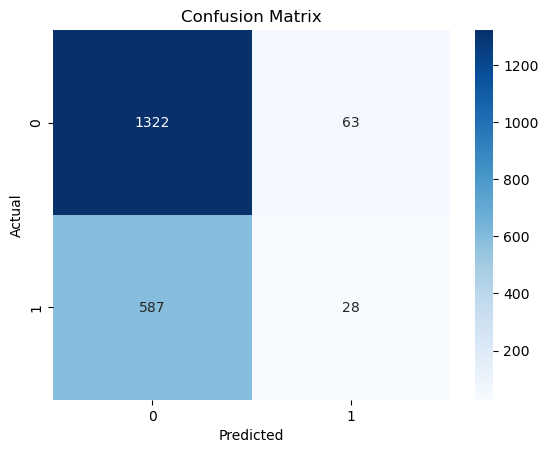

In [13]:
 # Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC CURVE

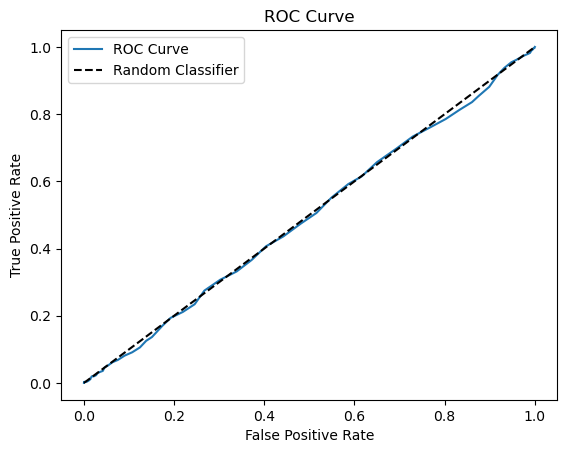

In [14]:
  # ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [15]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = model.predict(X_test_scaled)
y_prob_lr = model.predict_proba(X_test_scaled)[:, 1]

#   Calculating the evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr)

print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Precision: {precision_lr:.2f}")
print(f"Recall: {recall_lr:.2f}")
print(f"F1 Score: {f1_lr:.2f}")
print(f"AUC-ROC: {auc_lr:.2f}")

Accuracy: 0.68
Precision: 0.31
Recall: 0.05
F1 Score: 0.08
AUC-ROC: 0.50


FEATURE IMPORTANCE VISUALIZATION

In [16]:
# Get feature importance from the trained model
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_data = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_data = feature_importance_data.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_data)


              Feature  Importance
3       monthly_usage    0.294265
0                 age    0.198533
1              tenure    0.184014
5     last_login_days    0.181505
2       service_calls    0.085579
4  subscription_level    0.056104


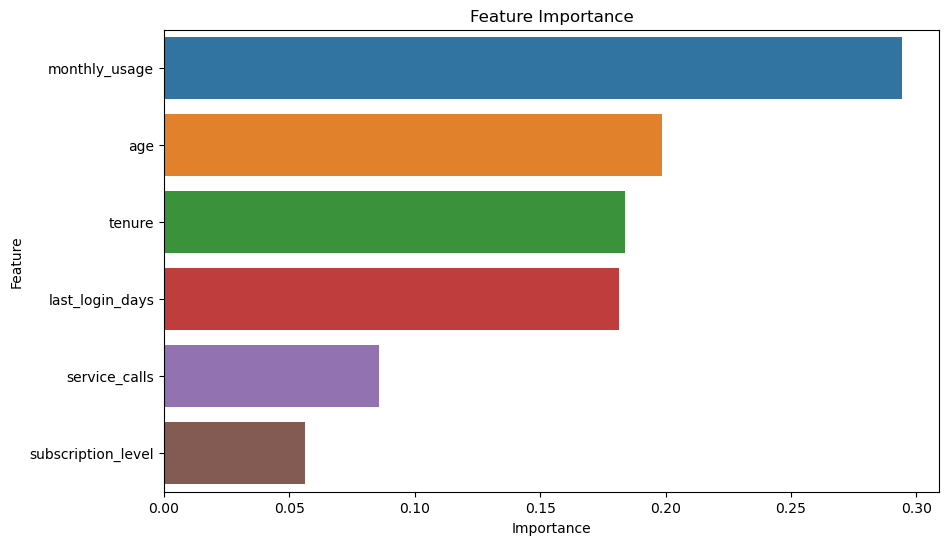

In [17]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_data)
plt.title('Feature Importance')
plt.show()


TO GET THE K-CROSS VALIDATION, SMOTE WOULD BE USE TO BALANCE THE DATASET

In [18]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# To perform K-Fold cross-validation with RandomForest
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')


print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.2f}")


Cross-Validation Accuracy Scores: [0.61237205 0.62038273 0.730187   0.75512021 0.74176313]
Mean Accuracy: 0.69


In [19]:
import joblib

# Save the trained model
joblib.dump(model, 'churn_prediction_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
